In [781]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import preprocessing, impute, model_selection, decomposition, cluster, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from statistics import mean
import math

### Import EPA Pollution and Census American Community Survey Data

In [1125]:
epa = pd.read_csv('../dataset/epa_pollution.csv')
census = pd.read_csv('../dataset/census_acs.csv')
aqi = pd.read_csv('../dataset/aqi_report.csv')

#only use data with common cbsa codes
common_cbsa = set(census['cbsa_code'])
common_cbsa = common_cbsa.intersection(set(epa['cbsa_code']))
common_cbsa = common_cbsa.intersection(set(aqi['cbsa_code']))

# Standardized cbsa code datasets
epa = epa[epa['cbsa_code'].isin(common_cbsa)].copy()
census = census[census['cbsa_code'].isin(common_cbsa)].copy()
aqi = aqi[aqi['cbsa_code'].isin(common_cbsa)].copy()

## Data Preprocessing

### Census ACS 

In [1126]:
# Remove redundant/irrelevant columns
census = census.drop(['metropolitan_area', 'city', 'state'], axis=1)

# Normalize columns
# Income
income = [i for i in census.columns if '$' in i]
for col in income:
    census[col] = census[col]/census['Income_Total']
census.drop('Income_Total', axis=1, inplace=True)

#Education
education = [i for i in census.columns if ('degree' in i) or ('graduate' in i)]
for col in education:
    census[col] = census[col]/census['Education_Total']
census.drop('Education_Total', axis=1, inplace=True)

# Occupation
occupation = [i for i in census.columns if (i not in income) and (i not in education) and (i not in ['cbsa_code', 'year', 'Occupation_Total'])]
for col in occupation:
    census[col] = census[col]/census['Occupation_Total']
census.drop('Occupation_Total', axis=1, inplace=True)

census.head()

,cbsa_code,Less than high school graduate,High school graduate (includes equivalency),Some college or associate's degree,Bachelor's degree,Graduate or professional degree,"$45,000 to $49,999","$50,000 to $59,999","$60,000 to $74,999","$75,000 to $99,999",...,"Educational services, and health care and social assistance","Arts, entertainment, and recreation, and accommodation and food services","Other services, except public administration",Public administration,"Management, business, science, and arts occupations",Service occupations,Sales and office occupations,"Natural resources, construction, and maintenance occupations","Production, transportation, and material moving occupations",year
1,10420,0.109590,0.342669,0.266596,0.183831,0.097314,0.043547,0.085722,0.105218,0.116918,...,0.224313,0.087933,0.047411,0.029834,0.341412,0.164147,0.268786,0.001810,0.223845,2005
2,10500,0.214530,0.323630,0.276552,0.115232,0.070055,0.046814,0.099690,0.111882,0.087279,...,0.221430,0.066773,0.066212,0.076664,0.300161,0.138019,0.246350,0.009773,0.305697,2005
3,10580,0.097922,0.308826,0.284550,0.169404,0.139298,0.046200,0.092376,0.111600,0.137878,...,0.259730,0.069128,0.038137,0.110608,0.397041,0.151805,0.270669,0.002259,0.178227,2005
4,10740,0.140155,0.265774,0.293919,0.169377,0.130775,0.043810,0.083659,0.113831,0.102810,...,0.223604,0.094226,0.045499,0.063296,0.374627,0.166710,0.264363,0.002006,0.192294,2005
5,10780,0.176673,0.371108,0.262197,0.136293,0.053729,0.041082,0.072454,0.070793,0.091749,...,0.302493,0.063796,0.038255,0.085138,0.334400,0.170620,0.256644,0.007136,0.231201,2005


In [857]:
census.shape

(4644, 33)

In [1030]:
soc_econ = census

#### PCA

Since there are 33 attributes and only 5K instances, it may not be sufficient for a successful clustering analysis.

In [845]:
#Capture 90% variance 
pca = decomposition.PCA(n_components=.90, svd_solver='full')

#only apply PCA on the continious variables 
continuous = census.drop(['cbsa_code', 'year'], axis=1)
reduced_census = pd.DataFrame(pca.fit_transform(continuous))
reduced_census['cbsa_code'] = census['cbsa_code']
reduced_census['year'] = census['year']

census_df = reduced_census.sort_values(['cbsa_code', 'year'], axis=0)
census_df.shape

(4644, 11)

### Clean AQI Report

In [1127]:
temp_df = pd.DataFrame()
for year in aqi['year'].unique():
    for cbsa in aqi['cbsa_code'].unique():
        curr = aqi[(aqi['year'] == year) & (aqi['cbsa_code'] == cbsa)]
        if curr.shape[0] > 0:
            temp_df = temp_df.append(curr.iloc[0,:], ignore_index=True)
aqi = temp_df.copy()

In [1128]:
# Normalize the days for each air quality with the total AQI days
qualities = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy']
for quality in qualities:
    aqi.loc[:, quality] = aqi[quality] / aqi['# Days with AQI']
    
aqi.sort_values(['cbsa_code', 'year'], inplace=True, axis=0)
aqi.drop(columns="# Days with AQI", inplace=True)

### EPA Pollution

Clean up data such that each instance contains all pollutants for each cbsa

In [185]:
durations = ['1 HOUR','24-HR BLK AVG', '24 HOUR', '3-HR BLK AVG', '8-HR RUN AVG END HOUR', '8-HR RUN AVG BEGIN HOUR', '5 MINUTE', 'INTEGRATED PASSIVE 4-WEEKS', 'INTEGREATED PASSIVE 3-WEEKS']
first_duration = {'PM2.5': '1 HOUR',
                  'Ozone': '8-HR RUN AVG END HOUR',
                  'Carbon_monoxide': '1 HOUR',
                  'Sulfur_dioxide': '1 HOUR'}

## Create new pollution DF with all the pollutants for every instance
pollution_df = pd.DataFrame()
for year in range(2005, 2020):
    for code in common_cbsa:
        new_row = {'year': year,
                   'cbsa_code': code}

        #average all records for year and code into one instance
        for k, v in first_duration.items():
            pollutant = pollution[(pollution['year'] == year) & (pollution['cbsa_code'] == code) & (pollution['parameter'].str.contains(k.replace('_', ' ')))]
            avg_poll = pollutant[pollutant['sample_duration'] == v]
            new_row[k + '_sample_duration'] = v
            
            #If no instances matching the sample duration exist, then we look for other
            for duration in durations:
                if avg_poll.shape[0] != 0: break
                avg_poll = pollutant[pollutant['sample_duration'] == duration]
                new_row[k + '_sample_duration'] = duration
            
            if avg_poll.shape[0] == 0: 
                new_row[k + '_sample_duration'] = np.nan
            
            attributes = ['arithmetic_mean', 'standard_deviation', 'ninety_ninth_percentile', 'seventy_fifth_percentile']
            for attr in attributes:
                new_row[k + '_' + attr] = pollutant[attr].mean()

        # Add matching AQI report to index
        aqi_dict = aqi[(aqi['cbsa_code'] == code) & (aqi['year'] == year)]
        for col in aqi_dict.columns:
            if col != 'year' and col != 'cbsa_code':
                new_row[col] = aqi_dict.iloc[0, :][col] if (aqi_dict.shape[0] != 0) else None
                
        pollution_df = pollution_df.append(new_row, ignore_index=True)
        
pollution_df.sort_values(['cbsa_code', 'year'], inplace=True, axis=0)

#### Fill and Impute Missing Values

In [186]:
# Fill nan pollution values with recent year values
for code in common_cbsa:
    pollution_df[pollution_df['cbsa_code'] == code] = pollution_df[pollution_df['cbsa_code'] == code].fillna(method='ffill', axis=0) ## Fill forward to bring last completed year forward
    pollution_df[pollution_df['cbsa_code'] == code] = pollution_df[pollution_df['cbsa_code'] == code].fillna(method='bfill', axis=0) ## Fill backward to impute missing values in earlier years

In [187]:
#Impute sample duration with mode
si = impute.SimpleImputer( strategy='most_frequent')
dur_labels = [col for col in pollution_df.columns if 'duration' in col]
pollution_df[dur_labels] = si.fit_transform(pollution_df[dur_labels])

# Label encode all sample_duration columns
le = preprocessing.LabelEncoder()
le.fit(durations)
for col in dur_labels:
    pollution_df[col] = le.transform(pollution_df[col])

In [188]:
# Fill in remaining values with average
si = impute.SimpleImputer()
pollution_df = pd.DataFrame(si.fit_transform(pollution_df), columns=pollution_df.columns)

In [189]:
pollution_df.sort_values(['cbsa_code', 'year'], inplace=True, axis=0)
pollution_df.to_csv('../dataset/epa_pollution_clean.csv', index=False)

In [190]:
temp_poll = pollution_df.copy()

#### PCA

Since there are 33 attributes and only 5K instances, it may not be sufficient for a successful clustering analysis.

In [191]:
#Capture 90% variance 
pca = decomposition.PCA(n_components=.90, svd_solver='full')

#only apply PCA on the continious variables 
continuous = pollution_df.drop(['cbsa_code', 'year'], axis=1)
continuous = continuous.drop(dur_labels, axis=1)
reduced_epa = pd.DataFrame(pca.fit_transform(continuous))
reduced_epa['cbsa_code'] = pollution_df['cbsa_code']
reduced_epa['year'] = pollution_df['year']
for duration in dur_labels:
    reduced_epa[duration] = pollution_df[duration]

reduced_epa.sort_values(['cbsa_code', 'year'], inplace=True, axis=0)
# reduced_epa.to_csv('../dataset/epa_pollution_clean.csv', index=False)
reduced_epa.shape

(5085, 10)

In [192]:
pca_poll = reduced_epa.copy()

## Symbol Encoding with Clusters

### K-Means clustering on EPA pollution + AQI dataset

In [193]:
kmm = cluster.KMeans(n_clusters=5, random_state=27)
kmm.fit_predict(reduced_epa.drop(columns=['year', 'cbsa_code']))
reduced_epa['cluster'] = kmm.labels_
reduced_epa.to_csv('../dataset/epa_aqi_clustered.csv', index=False)

c:\users\suchi\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### K-Means clustering on AQI

In [1129]:
kmm = cluster.KMeans(n_clusters=3, random_state=27, init='random')
kmm.fit_predict(aqi.drop(columns=['cbsa_code', 'year']))
aqi['cluster'] = kmm.labels_

### K-Means clustering on ACS

In [1130]:
kmm = cluster.KMeans(n_clusters=3, random_state=27, init='random')
kmm.fit_predict(census.drop(columns=['cbsa_code', 'year']))
census['cluster'] = kmm.labels_

### Explore clusters

In [1131]:
cluster_info = pd.DataFrame()
for clus in aqi['cluster'].unique():
    new_row = dict()
    cluster_aqi = aqi[aqi['cluster'] == clus]
    for col in cluster_aqi:
        new_row[col] = cluster_aqi[col].mean()
        
    cluster_info = cluster_info.append(new_row, ignore_index=True)
    
cluster_info.sort_values(['Unhealthy for Sensitive Groups'], inplace=True, axis=0, ascending=False)
aqi_clusters = list(cluster_info['cluster'])
print(aqi_clusters)
cluster_info

[0.0, 2.0, 1.0]


,Good,Moderate,Unhealthy for Sensitive Groups,Unhealthy,Very Unhealthy,AQI Maximum,AQI 90th Percentile,AQI Median,# Days CO,# Days NO2,# Days O3,# Days SO2,# Days PM2.5,# Days PM10,year,cbsa_code,cluster
0,0.599446,0.348119,0.042921,0.008555,0.000959,150.873169,77.905937,46.501157,1.122591,7.220123,139.469160,19.164225,168.157672,9.575173,2011.757132,30032.455667,0.0
2,0.755441,0.217957,0.023665,0.002740,0.000197,127.531573,67.683410,41.420494,0.904707,6.402985,261.018944,5.497130,54.387486,8.710677,2012.242250,30460.137773,2.0
1,0.687246,0.297825,0.012131,0.002546,0.000252,121.235593,63.688136,37.782203,0.874576,0.528814,30.064407,4.189831,313.208475,5.166102,2012.116949,30005.898305,1.0


In [1132]:
cluster_info = pd.DataFrame()
for clus in census['cluster'].unique():
    new_row = dict()
    cluster_census = census[census['cluster'] == clus]
    for col in cluster_census:
        new_row[col] = cluster_census[col].mean()
        
    cluster_info = cluster_info.append(new_row, ignore_index=True)
    
    
cluster_info.sort_values(["Graduate or professional degree"], inplace=True, axis=0)
cluster_info.drop(columns=['cbsa_code', 'year']).to_csv('census_cluster_info.csv', index=True)
census_clusters = list(cluster_info['cluster'])
print(census_clusters)
cluster_info

[0.0, 2.0, 1.0]


,cbsa_code,Less than high school graduate,High school graduate (includes equivalency),Some college or associate's degree,Bachelor's degree,Graduate or professional degree,"$45,000 to $49,999","$50,000 to $59,999","$60,000 to $74,999","$75,000 to $99,999",...,"Arts, entertainment, and recreation, and accommodation and food services","Other services, except public administration",Public administration,"Management, business, science, and arts occupations",Service occupations,Sales and office occupations,"Natural resources, construction, and maintenance occupations","Production, transportation, and material moving occupations",year,cluster
0,30680.158633,0.144637,0.338782,0.292936,0.145462,0.078184,0.047042,0.087458,0.106788,0.117924,...,0.087204,0.047886,0.042412,0.309118,0.173501,0.248279,0.039324,0.229777,2009.684564,0.0
2,31123.821571,0.147782,0.294468,0.323452,0.151154,0.083143,0.044656,0.082608,0.103217,0.117175,...,0.106003,0.049233,0.058304,0.318505,0.199410,0.243485,0.105624,0.132975,2013.621838,2.0
1,28550.439122,0.095661,0.244017,0.293841,0.220383,0.146098,0.040234,0.078595,0.103019,0.128889,...,0.096641,0.046974,0.051448,0.408700,0.173719,0.231696,0.065151,0.120734,2013.500333,1.0


### Re-map with clusters

In [1133]:
def cluster_encode(cluster_num, data, census_code, aqi_code):    
    if data == 'aqi':
        return aqi_code.index(cluster_num)
    elif data == 'census':
        return census_code.index(cluster_num)

In [1134]:
# census_clusters = [i for i in range(4)]
# aqi_clusters = [i for i in range(4)]
# Remap cluster labels
aqi['cluster'] = [cluster_encode(i, 'aqi', census_clusters, aqi_clusters) for i in aqi['cluster']]
census['cluster'] = [cluster_encode(i, 'census', census_clusters, aqi_clusters) for i in census['cluster']]
 
# Store files
aqi.to_csv('../dataset/aqi_clustered.csv', index=False)
census.to_csv('../dataset/census_clustered.csv', index=False)

In [1135]:
# Create classification data
aqi.sort_values(["cbsa_code", 'year'], inplace=True, axis=0)
census.sort_values(["cbsa_code", 'year'], inplace=True, axis=0)
classification_data = census.drop(columns=['cluster'])
target_list=list()
for year, cbsa in zip(census['year'], census['cbsa_code']):
    cluster_val = aqi[(aqi['year'] == year) & (aqi['cbsa_code'] == cbsa)]['cluster']
    target_list.append(list(cluster_val)[0] if cluster_val.shape[0] != 0 else None)

classification_data['aqi_cluster'] = target_list
classification_data = classification_data.dropna(axis=0)
classification_data.to_csv('../dataset/classification_census_aqi.csv', index=False)

In [1136]:
classification_data.shape

(4516, 34)

### Encode Clusters with appropriate values and Impute

In [1137]:
cluster_df = pd.DataFrame()
# Create rows for all years and cbsa
for year in range(2005, 2020):
    for code in common_cbsa:
        #define new row
        new_row = {'year': year,
                   'cbsa_code': code}
        
        #find the rows that match the year and cbsa
        curr_census = census[(census['year'] == year) & (census['cbsa_code'] == code)] 
        new_row['census_cluster'] = cluster_encode(list(curr_census['cluster'])[0], 'census', census_clusters, aqi_clusters) if curr_census.shape[0] == 1 else None
        curr_aqi = aqi[(aqi['year'] == year) & (aqi['cbsa_code'] == code)]
        new_row['aqi_cluster'] = cluster_encode(list(curr_aqi['cluster'])[0], 'aqi', census_clusters, aqi_clusters) if curr_aqi.shape[0] == 1 else None
        
        # add new row 
        cluster_df = cluster_df.append(new_row, ignore_index=True)
        
    #Impute missing values
    cluster_df = cluster_df.fillna(method='bfill', axis=0, limit=3)
    cluster_df = cluster_df.fillna(method='ffill', axis=0)

cluster_df.sort_values(['cbsa_code', 'year'], inplace=True, axis=0) #sort the values
print(cluster_df.shape)
print(len(cluster_df['cbsa_code'].unique()))

(5085, 4)
339


In [1138]:
cluster_df['aqi_cluster'].value_counts()

0.0    2678
2.0    1797
1.0     610
Name: aqi_cluster, dtype: int64

### Cross Correlation

In [1139]:
# Time lagged cross correlation
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag), min_periods=3)

In [1154]:
lag_corr = dict()
for lag in range(-7, 8):
    correlation = dict()
    for cbsa in common_cbsa:
        df = cluster_df[cluster_df['cbsa_code'] == cbsa].drop(columns=['cbsa_code', 'year'])

        correlation[cbsa] = crosscorr( df['aqi_cluster'], df['census_cluster'], lag)
    
    lag_corr[lag] = mean([abs(i) for i in correlation.values() if not math.isnan(i)])
    
lag_corr = {k:v for k,v in sorted(lag_corr.items(), key=lambda item:item[1])}
lag_corr

{-4: 0.28364390032044556,
 0: 0.3024978461207976,
 -5: 0.30566300963345916,
 -3: 0.31167800772810644,
 -2: 0.3191007240504136,
 -1: 0.3206509465543948,
 3: 0.3268624225605685,
 2: 0.32868485034413264,
 -6: 0.3327875861102706,
 1: 0.3333100733315485,
 4: 0.35001079031491733,
 5: 0.35475477172877806,
 7: 0.3829994023263127,
 -7: 0.3933481059268247,
 6: 0.4044544601946759}

In [1153]:
correlation = dict()
for cbsa in common_cbsa:
    # only keep clusters (two vectors)
    df = cluster_df[cluster_df['cbsa_code'] == cbsa].drop(columns=['cbsa_code', 'year'])
    
    #find the best lag for this cbsa
    lag_corr = dict()
    for lag in range(-7, 8):
        lag_corr[lag] = crosscorr(df['aqi_cluster'], df['census_cluster'], lag)
        
    lag_corr = {k:v for k,v in lag_corr.items() if not np.isnan(v)}
    lag_corr = {k:v for k,v in sorted(lag_corr.items(), key=lambda item:item[1], reverse=True)}
    
    if len(list(lag_corr.items())) != 0:
        top_lag = list(lag_corr.items())[0][0] #get the lag
        correlation[cbsa] = crosscorr(df['aqi_cluster'], df['census_cluster'], top_lag)
        
print(mean([abs(i) for i in correlation.values() if not math.isnan(i)]))

0.5531777789891733


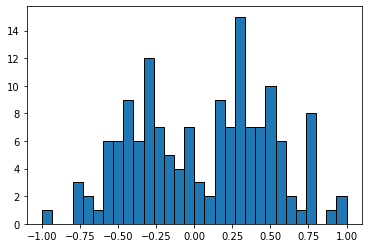

In [1164]:
correlation = dict()
for cbsa in common_cbsa:
    df = cluster_df[cluster_df['cbsa_code'] == cbsa].drop(columns=['cbsa_code', 'year'])

    correlation[cbsa] = crosscorr( df['aqi_cluster'], df['census_cluster'], lag)
    
correlation = {k:v for k,v in correlation.items() if not np.isnan(v)}
correlation = {k:v for k,v in sorted(correlation.items(), key=lambda item:item[1])}

plt.hist(correlation.values(),edgecolor='black', bins=30)
# plt.title('AQI & US Census CBSA Cluster Correlation')
plt.savefig('correlation_hist.png')
plt.show()

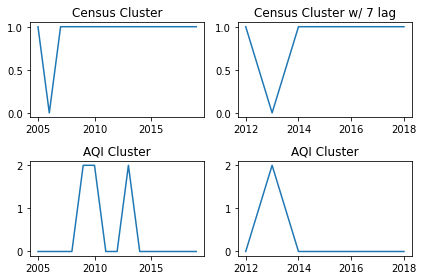

In [1152]:
# Show how lag helps with correlation
fig, axs = plt.subplots(2, 2)
df = cluster_df[cluster_df['cbsa_code'] == 17780]

axs[0, 0].plot(df['year'], df['census_cluster'])
axs[1, 0].plot(df['year'], df['aqi_cluster'])

axs[1, 0].set_title('AQI Cluster')
axs[0, 0].set_title('Census Cluster')

axs[0, 1].plot(df['year'].iloc[7:14], df['census_cluster'].shift(7).iloc[7:14])
axs[1, 1].plot(df['year'].iloc[7:14], df['aqi_cluster'].iloc[7:14])

axs[1, 1].set_title('AQI Cluster')
axs[0, 1].set_title('Census Cluster w/ 7 lag')

fig.tight_layout()
fig.savefig('symbol_encoding.png')

In [787]:
def k_fold_validate(folds, model, features, target, model_type, output=True):
    kf = model_selection.KFold(n_splits=folds, shuffle=True, random_state=3)
    
    rec, prec, f1 = [], [], []
    imp_df = pd.DataFrame()
    for train_index, test_index in kf.split(features):
        # Retrieve the train and test sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Standardize the data to optimize performance
        scaler = preprocessing.StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate the model
        rec += [metrics.recall_score(y_pred, y_test, average='weighted')]
        prec += [metrics.precision_score(y_pred, y_test, average='weighted')]
        f1 += [metrics.f1_score(y_pred, y_test, average='weighted')]
        
        # Store the feature importances for the fold
        if model_type == 'lrm':
            imps = abs(model.coef_[0])
        elif model_type == 'dtm' or model_type == 'rfm':
            imps = model.feature_importances_
        elif model_type == 'nbm':
            imps = inspection.permutation_importance(model, X_test, y_test).importances_mean
          
        imps = {k:v for k,v in enumerate(imps)}
        imp_df = imp_df.append(imps, ignore_index=True)
        
    if output:
        print("recall    = {:.4f} ±{:.4f} {}".format(np.mean(rec), np.std(rec), rec))
        print("precision = {:.4f} ±{:.4f} {}".format(np.mean(prec), np.std(prec), prec))
        print("f1        = {:.4f} ±{:.4f} {}".format(np.mean(f1), np.std(f1), f1))
    
    scores = {'recall': [np.mean(rec), np.std(rec)],
              'precision': [np.mean(prec), np.std(prec)],
              'f1': [np.mean(f1), np.std(f1)],
              'feature_ranks': {k:v for k, v in enumerate(imp_df.mean(axis=0))}            
             }        
        
    return scores

In [803]:
# Create features and target 
X = census.drop(columns=['cluster'])
target = 'aqi_cluster'
y = cluster_df[[target, 'year', 'cbsa_code']]

In [804]:
# Create rows for all years and cbsa
for year in range(2005, 2020):
    for code in common_cbsa:
        #define new row
        new_row = {'year': year,
                   'cbsa_code': code}
        
        
        #find the rows that match the year and cbsa
        curr_census = X[(X['year'] == year) & (X['cbsa_code'] == code)] 
        if curr_census.shape[0] == 0:
            new_row.update({k:None for k in X.columns})
            X = X.append(new_row, ignore_index=True)
            
        curr_aqi = y[(y['year'] == year) & (y['cbsa_code'] == code)]
        if curr_aqi.shape[0] == 0:
            new_row[target] = None
            y = y.append(new_row, ignore_index=True)
        
        
    # #Impute missing values
    # cluster_df = cluster_df.fillna(method='bfill', axis=1, limit=3)
    # cluster_df = cluster_df.fillna(method='ffill', axis=1)

X.sort_values(['cbsa_code', 'year'], inplace=True, axis=0) #sort the values
y.sort_values(['cbsa_code', 'year'], inplace=True, axis=0) #sort the values

data = X.copy()
data[target] = y[target]

# Drop na values
data = data.dropna()

# Drop irrelevant columns
X = data.drop(columns=['year', target])
y = data[target]



c:\users\suchi\appdata\local\programs\python\python38\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [805]:
X.shape

(4644, 32)

In [807]:
y.value_counts()

3.0    2102
1.0    1605
0.0     500
2.0     413
4.0      24
Name: aqi_cluster, dtype: int64

In [772]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3, random_state=17, shuffle=True)
# Small Dataset
lrm = LogisticRegression()
lrm.fit(X_train, y_train)
lrm.score(X_test, y_test)

ValueError: Unknown label type: 'continuous'

### Decision Tree

In [808]:
# Small Dataset
dtm = DecisionTreeClassifier()
scores = k_fold_validate(5, dtm, X, y, 'dtm')

recall    = 0.3553 ±0.0141 [0.34660925726587727, 0.3326157158234661, 0.37029063509149623, 0.35844994617868675, 0.36853448275862066]
precision = 0.3514 ±0.0104 [0.34964910790631365, 0.3334426909842384, 0.36476715457681336, 0.35135074668437277, 0.357609714516184]
f1        = 0.3529 ±0.0121 [0.3478227805070351, 0.33260934531060743, 0.3673406687368896, 0.35468095488785667, 0.36229428007212]


### Random Forest

In [118]:
# Small Dataset
rfm = RandomForestClassifier()
scores = k_fold_validate(5, rfm, Xs, ys, 'rfm')
og_small_score['rfm'] = scores['f1'][0]
imp_small = imp_small.append(scores['feature_ranks'], ignore_index=True)

recall    = 0.1099 ±0.0321 [0.08536585365853659, 0.07608695652173914, 0.16666666666666666, 0.12048192771084337, 0.10112359550561797]
precision = 0.1040 ±0.0148 [0.08235294117647059, 0.08974358974358974, 0.11458333333333333, 0.11627906976744186, 0.11688311688311688]
f1        = 0.1058 ±0.0205 [0.08383233532934131, 0.08235294117647059, 0.13580246913580246, 0.1183431952662722, 0.10843373493975904]


### Naive Bayes

In [120]:
# Small Dataset
nbm = GaussianNB()
scores = k_fold_validate(5, nbm, Xs, ys, 'nbm')
og_small_score['nbm'] = scores['f1'][0]
imp_small = imp_small.append(scores['feature_ranks'], ignore_index=True)

recall    = 0.3375 ±0.1281 [0.45454545454545453, 0.14285714285714285, 0.49206349206349204, 0.34146341463414637, 0.2564102564102564]
precision = 0.3783 ±0.2863 [0.7647058823529411, 0.02564102564102564, 0.6458333333333334, 0.32558139534883723, 0.12987012987012986]
f1        = 0.3356 ±0.2082 [0.5701754385964911, 0.043478260869565216, 0.5585585585585586, 0.33333333333333337, 0.17241379310344826]
